# Projecting the growth of OA: a large scale extrapolation




**Heather Piwowar, Jason Priem, Richard Orr**  (order tbd)   
_Our Research (team@ourresearch.org)_

First published: September 23, 2019

## Introduction


The adoption of [open access (OA)](https://en.wikipedia.org/wiki/Open_access) publishing is changing scholarly communication. Predicting the future prevalence of OA is crucial for many stakeholders making decisions now, including:

-   libraries deciding which journals to subscribe to and how much they should pay

-   institutions and funders deciding what mandates they should adopt, and the implications of existing mandates

-   scholarly publishers deciding when to flip their business models to OA

-   scholarly societies deciding how best to serve their members.

Despite how useful OA prediction would be, only a few studies have made an attempt to empirically predict open access rates. Lewis (2012) extrapolated the rate at which [gold OA](https://en.wikipedia.org/wiki/Open_access#Gold_OA) would replace subscription-based publishing using a simple log linear extrapolation of gold vs subscription market share. Antelman (2017) used one empirically-derived growth rate for [green OA](https://en.wikipedia.org/wiki/Open_access#Green_OA) and another for all other kinds of OA combined. Both of these studies are based on data collected before 2012, and rely on relatively simple models. Moreover, these studies predict the number of papers that are OA. While this number is important, it is arguably less meaningful than the number of accesses that are OA, since this latter number describes the prevalence of OA as experienced by actual readers.

This paper aims to address this gap in the literature. In it, we build a detailed model using data extrapolated from large and up-to-date Unpaywall dataset (https://unpaywall.org/).  We use the model to predict the number of articles that will be OA (including gold, green, hybrid, and bronze OA) over the next five years, and also use data from the Unpaywall browser add-on (https://unpaywall.org/products/extension) to predict the proportion of scholarly article accesses that will lead readers to OA articles over time.

The method presented here aims to provide a useful model of OA growth, taking the following complexities into account:

-   some forms of OA include a delay between when a paper is first published and when it is first freely available

-   different forms of open access are being adopted at different rates

-   wide-sweeping policy changes, technical improvements, or cultural changes may cause disruptions in the growth rates of OA in the future

Future work will allow the model to predict the growth of Open Access for individual disciplines, journals, and article selections.


## Data

The data used in this analysis comes from two sources: (1) the Unpaywall dataset and (2) the access logs of the Unpaywall web browser extension.

### OA status: the Unpaywall dataset of OA availability

Predicting levels of open access publication in the future requires detailed, accurate, timely data.. This study uses the [Unpaywall](https://unpaywall.org/) dataset to provide this data.. Unpaywall is an open source application that  links every research article that has been assigned a Crossref DOI (more than 100 million in total) to the OA URLs where the paper can be read for free. It  is built and maintained by Our Research (formerly Impactstor), a US-based nonprofit organization. Unpaywall gathers data gathered from over 50,000 journals and open-access repositories from all over the world. The full Unpaywall dataset is freely, publicly available (see details: <https://unpaywall.org/user-guides/research>).

This analysis uses all articles with a Crossref article type of "journal-article" published between 1950 and 2018.  [num of articles? 70891275]

Our definitions of OA type (gold, green, hybrid, bronze, closed) are described in Piwowar et al. (2018). To facilitate prediction, for the purpose of this analysis we subdivided bronze OA into immediate and delayed OA. In summary, these definitions are:

-   Gold: published in a fully-OA journal

-   Hybrid: published in a toll-access journal, with an OA license

-   Bronze: published in a toll-access journal, without an OA license

-   Immediate Bronze: OA on publication

-   Delayed Bronze: OA later

-   Green: published in a toll-access journal, with a fulltext copy available in an OA repository

-   Closed: everything else

### Relative download patterns: access logs of the Unpaywall web browser extension

Predicting the open access pattern of usage requests requires knowing the relative usage demands of papers based on their age and subject matter. This study has extracted these download patterns from the usage logs of the [Unpaywall browser extension](https://unpaywall.org/products/extension) for Chrome and Firefox.

This extension is an open-source tool made by the same non-profit as the Unpaywall dataset described above, with the goal of helping people conveniently find free copies of research papers directly from their web browser. The extension has more than 200,000 active users and has received more than 50 million access requests between August 2018 and August 2019. Because readership data is private and potentially sensitive, we are not releasing the Unpaywall usage logs along with the other datasets behind this paper.

[add more about strengths and weaknesses of this data. make a case for why it's representative. add the IP address graphs.]

[add more descriptive stats: num events, num journals, num countries, etc.]

## Methods and Results


### Analysis

The analysis was writen as an executable python Jupyter notebook using the pandas, scipy, matplotlib, and sqlalchemy libraries. See the Data Availability section below for links to the code.

*---- delete the text between these lines in the final paper ----*

#### Code: Initialization

See notebook.

In [135]:
%%capture --no-stderr --no-stdout --no-display

# hidden: code to import libraries, set up database connection, other initialization
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd
import numpy as np
import scipy
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
from sqlalchemy import create_engine
import psycopg2
from datetime import timedelta

redshift_engine = create_engine(os.getenv("DATABASE_URL_REDSHIFT"))

oa_status_order = ["green", "gold", "hybrid", "bronze", "closed"]
oa_status_colors = ["green", "gold", "orange", "brown", "grey"]
oa_color_lookup = pd.DataFrame(data = {"name": oa_status_order, "color": oa_status_colors, "order": range(0, len(oa_status_order))})
my_cmap = sns.color_palette(oa_status_colors)

graph_type_order = ["green", "gold", "hybrid", "immediate_bronze", "delayed_bronze", "closed"]
graph_type_colors = ["green", "gold", "orange", "brown", "peru", "gray"]
graph_type_lookup = pd.DataFrame(data = {"name": graph_type_order, "color": graph_type_colors, "order": range(0, len(graph_type_order))})
my_cmap_graph_type = sns.color_palette(graph_type_colors)

# graph style
sns.set(style="ticks")

# long print, wrap
pd.set_option('display.expand_frame_repr', False)


#### Code: Functions

See notebook.

In [169]:
%%capture --no-stderr --no-stdout --no-display

def get_naive_papers(graph_type, use_graph_type=False, label_for_graph=None, now_delta_years=0, show_graph=True, cumulative=True):
    
    calc_min_year = 1951
    display_min_year = 2010
    now_year = 2019 - now_delta_years
    max_year = 2024

    min_y = 0
    max_y = None
    color = graph_type
    if "bronze" in graph_type:
        color = "bronze"
        
    if graph_type in ("green", "hybrid"):
        now_year -= 1
    if graph_type in ("delayed_bronze", "closed"):
        now_year -= 5
                
    if use_graph_type:
        df_this_color = unpaywall_graph_type.loc[(unpaywall_graph_type.graph_type==graph_type)]
    else:
        df_this_color = unpaywall_data_by_year.loc[(unpaywall_data_by_year.oa_status==color)]

    totals = pd.DataFrame()
    for i, prediction_year in enumerate(range(calc_min_year, now_year)):

        if cumulative:
            df_this_plot = df_this_color.loc[(df_this_color["published_year"] <= prediction_year)]
        else:
            df_this_plot = df_this_color.loc[(df_this_color["published_year"] == prediction_year)]
        y = [a for a in df_this_plot["num_articles"] if not np.isnan(a)]
        prediction_y = sum(y)

        totals = totals.append(pd.DataFrame(data={"prediction_year": [prediction_year], 
                                             "num_articles": [prediction_y]}))

        
    x = totals["prediction_year"]
    y = totals["num_articles"]
#     f = scipy.interpolate.interp1d(x, np.log10(y), fill_value="extrapolate", kind="linear")
    f = scipy.interpolate.interp1d(x, y, fill_value="extrapolate", kind="linear")
    xnew = np.arange(now_year-1, max_year+1, 1)
#     ynew = 10 ** f(xnew)
    ynew = f(xnew)
    
    new_data = pd.DataFrame({"color":color, "graph_type": graph_type, "x":np.append(x[:-1], xnew), "y":np.append(y[:-1], ynew)})

    return new_data


def graph_naive_papers(graph_type, use_graph_type=False, label_for_graph=None, now_delta_years=0, show_graph=True, ax=None, cumulative=True):
    calc_min_year = 1951
    display_min_year = 2010
    now_year = 2019 - now_delta_years
    max_year = 2024

    min_y = 0
    max_y = None
    color = graph_type
    if "bronze" in graph_type:
        color = "bronze"
    
    new_data = get_naive_papers(graph_type, use_graph_type, label_for_graph, now_delta_years, show_graph, cumulative)

    # graph!  :)
    year_range = range(display_min_year, now_year)
    
    if use_graph_type:
        my_color_lookup = graph_type_lookup.loc[graph_type_lookup["name"]==graph_type]
    else:
        my_color_lookup = oa_color_lookup.loc[oa_color_lookup["name"]==color]

        
    if not ax:
        fig = plt.figure()
        ax = plt.subplot(111)

    if not max_y:
        max_y = 5 * max(new_data["y"])


    df_actual = new_data.loc[new_data["x"] < now_year]
    x = [int(a) for a in df_actual["x"]]
    y = [int(a) for a in df_actual["y"]]
    df_future = new_data.loc[new_data["x"] >= now_year]
    xnew = [int(a) for a in df_future["x"]]
    ynew = [int(a) for a in df_future["y"]]

    ax.plot(x, y, 'o', color="black")
    ax.fill_between(x, y, color=my_color_lookup["color"])

    ax.plot(xnew, ynew, 'o', color="black", alpha=0.3)
    ax.fill_between(xnew, ynew, color=my_color_lookup["color"], alpha=0.3)
    if cumulative:
        title = plt.suptitle("Extrapolating CUMULATIVE number of papers, by OA type")
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.0f}'.format(y/(1000*1000.0))))
        ax.set_ylabel("CUMULATIVE papers (millions)")
        ax.set_xlabel("year")
    else:
        title = plt.suptitle("Extrapolating papers by year of publication, by OA type")
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.1f}'.format(y/(1000*1000.0))))
        ax.set_ylabel("number of papers (millions)")
        ax.set_xlabel("year of publication")
    ax.set_xlim(min(year_range), max_year)
#     ax.set_ylim(min_y, max_y)
    title.set_position([.5, 1.05])

#     plt.show()
    return new_data

In [147]:
%%capture --no-stderr --no-stdout --no-display

# graph!  :)

def graph_available_papers_at_year_of_availability(graph_type, now_delta_years=0, label_for_graph=None, show_graph=True, ax=None):
    calc_min_year = 1951
    display_min_year = 2010
    now_year = 2018 - now_delta_years
    max_year = 2024

    color = graph_type
    if "bronze" in graph_type:
        color = "bronze"

    if graph_type == "biorxiv":
        my_color_lookup = {"color": "limegreen"}
    else:
        my_color_lookup = graph_type_lookup.loc[graph_type_lookup["name"]==graph_type]        
        
    all_papers_per_year = get_papers_by_availability_year_including_future(graph_type, calc_min_year, max_year)

    most_recent_year = all_papers_per_year.loc[all_papers_per_year.article_years_from_availability == 0]
    
    x = [int(a) for a in most_recent_year.loc[most_recent_year.prediction_year <= now_year]["prediction_year"]]
    xnew = [int(a) for a in most_recent_year.loc[most_recent_year.prediction_year > now_year]["prediction_year"]]
    y = [int(a) for a in most_recent_year.loc[most_recent_year.prediction_year <= now_year]["num_articles"]]
    ynew = [int(a) for a in most_recent_year.loc[most_recent_year.prediction_year > now_year]["num_articles"]]

    year_range = range(display_min_year, now_year)
    if not ax:
        fig = plt.figure()
        ax = plt.subplot(111)

    max_y = 1.2 * max(ynew)

    ax.plot(x, y, 'o', color="black")
    ax.fill_between(x, y, color=my_color_lookup["color"])

    ax.plot(xnew, ynew, 'o', color="black", alpha=0.3)
    ax.fill_between(xnew, ynew, color=my_color_lookup["color"], alpha=0.3)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.2f}'.format(y/(1000*1000.0))))
    ax.set_ylabel("total papers (millions)")

    ax.set_xlim(min(year_range), max_year)
#         ax.set_ylim(0, max_y)
    if not label_for_graph:
        label_for_graph = color
    ax.set_xlabel('year of observation')
    title = plt.suptitle("OA status by observation year")
    title.set_position([.5, 1.05])
    return all_papers_per_year

In [148]:
%%capture --no-stderr --no-stdout --no-display

def graph_available_papers_in_observation_year_by_pubdate(graph_type, data, observation_year, ax=None):
    display_min_year = 2010
    max_year = 2024

    x = [int(a) for a in data["publication_date"]]
    y = [int(a) for a in data["num_articles"]]

    my_color_lookup = graph_type_lookup.loc[graph_type_lookup["name"]==graph_type]
    if not ax:
        fig = plt.figure()
        ax = plt.subplot(111)

    alpha = 1
    if observation_year > 2018:
        alpha = 0.3
    ax.bar(x, y, color=my_color_lookup["color"], alpha=alpha)

    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.1f}'.format(y/(1000*1000.0))))
    ax.set_xlim(display_min_year, max_year)
    max_y = 1.2 * data.num_articles.max()
    ax.set_ylim(0, max_y)
#     ax.set_xlabel('pub year')
#     ax.set_ylabel("papers (*10^6)")
    ax.set_title("{}".format(observation_year));  
#     title = plt.suptitle("Availability in {}, by publication date".format(observation_year))
#     title.set_position([.5, 1.05])
    return 



In [149]:
%%capture --no-stderr --no-stdout --no-display

def get_papers_by_availability_year_including_future(graph_type, start_year, end_year, exponential=False):
    start_calc_year = 2009
    now_year = 2017
    offset = 0
    
    my_return = pd.DataFrame()

    if graph_type == "closed":
        now_year -= 5
    elif graph_type == "green":
        now_year -= 1
    elif graph_type == "delayed_bronze":
        now_year -= 5
    elif graph_type == "hybrid":
        now_year -= 1
    elif graph_type == "biorxiv":
        now_year += 1
        exponential = True
        

    for prediction_year in range(min(start_year, start_calc_year), now_year+1):        
        papers_per_year = get_papers_by_availability_year(graph_type, prediction_year, just_this_year=False)
        papers_per_year["prediction_year"] = prediction_year
        my_return = my_return.append(papers_per_year)
        
    if end_year > now_year:
        last_calculated = my_return.loc[my_return["prediction_year"] == now_year]
        all_papers_per_year = my_return.loc[my_return["prediction_year"] <= now_year]
        most_recent_year = all_papers_per_year.loc[all_papers_per_year.article_years_from_availability == 0]
        x = [int(a) for a in most_recent_year.loc[most_recent_year.prediction_year <= now_year]["prediction_year"]]
        y = [int(a) for a in most_recent_year.loc[most_recent_year.prediction_year <= now_year]["num_articles"]]
        
#         print zip(x, y)
        
        xnew = np.arange(now_year+1, end_year+1, 1)
        if exponential:
            f = scipy.interpolate.interp1d(x, np.log10(y), fill_value="extrapolate", kind="linear")
            ynew = 10 ** f(xnew)
        else:
            f = scipy.interpolate.interp1d(x, y, fill_value="extrapolate", kind="linear")
            ynew = f(xnew)
        
        for i, prediction_year in enumerate(xnew): 
            scale = ynew[i]/y[-1]
            this_frame = last_calculated.copy()
            this_frame["num_articles"] = [int(scale * a) for a in this_frame["num_articles"]]
            this_frame["prediction_year"] = prediction_year
            add_me = pd.DataFrame(this_frame, columns=["num_articles", 
                                                      "article_years_from_availability", 
                                                      "prediction_year"])
            my_return = my_return.append(add_me)

    return my_return

In [150]:
%%capture --no-stderr --no-stdout --no-display

# graph!  :)

def graph_accesses(graph_type, now_delta_years=0, label_for_graph=None, show_graph=True, ax=None):
    calc_min_year = 1951
    display_min_year = 2010
    now_year = 2018 - now_delta_years
    max_year = 2024

    color = graph_type

    df_accesses_by_year = get_predicted_accesses(graph_type, display_min_year, max_year)

    year_range = range(display_min_year, now_year)
    if graph_type == "biorxiv":
        my_color_lookup = {"color": "limegreen"}
    else:
        my_color_lookup = graph_type_lookup.loc[graph_type_lookup["name"]==color]
        
    if not ax:
        fig = plt.figure()
        ax = plt.subplot(111)

    
    x = [int(a) for a in df_accesses_by_year["observation_year"]]
    y = [int(a) for a in df_accesses_by_year["accesses"]]
    max_y = 1.2 * max(y)

    ax.scatter(x, y, marker='x', s=70, color=my_color_lookup["color"])

    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.1f}'.format(y/(1000*1000.0))))
    ax.set_ylabel("number of accesses (millions)")

    ax.set_xlim(min(year_range), max_year+1)
#         ax.set_ylim(0, max_y)
    if not label_for_graph:
        label_for_graph = color
    ax.set_xlabel('access year')
    title = plt.suptitle("Estimated accesses by access year, by OA type")
    title.set_position([.5, 1.05])
    return df_accesses_by_year

In [151]:
%%capture --no-stderr --no-stdout --no-display

# do calculations

def get_papers_by_availability_year(graph_type, availability_year, just_this_year=False):
    my_return = pd.DataFrame()
        
    if just_this_year:
        if graph_type == "closed":
            rows_published_this_year = unpaywall_data_by_year.loc[unpaywall_data_by_year["published_year"] == availability_year]
            total_this_year = rows_published_this_year.num_articles.sum()
            
            open_this_year = 0
            for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze"]:
#             for prep_graph_type in ["hybrid", "green", "delayed_bronze"]:
                temp_papers = get_papers_by_availability_year(prep_graph_type, availability_year, just_this_year=False)
                temp_papers = temp_papers.loc[temp_papers.article_years_from_availability == 0]
                num_articles = temp_papers.num_articles.sum()
#                 print prep_graph_type, num_articles
                open_this_year += num_articles
            num_closed = total_this_year - open_this_year
            
            my_return = pd.DataFrame({
                "article_years_from_availability": [0],
                "num_articles": [num_closed]
            })
        else:
            prev_year_history = get_papers_by_availability_year(graph_type, availability_year-1, just_this_year=False)
            prev_year_history["article_years_from_availability"] += 1
            this_year_history = get_papers_by_availability_year(graph_type, availability_year, just_this_year=False)
            df_merged = this_year_history.merge(prev_year_history, on="article_years_from_availability", how="left")
            df_merged = df_merged.fillna(0)
            df_merged["num_articles"] = df_merged["num_articles_x"] - df_merged["num_articles_y"]
            df_merged["num_articles"][df_merged["num_articles"] < 25] = 0
            df_merged = df_merged.loc[df_merged["article_years_from_availability"] <= 10]
            my_return = pd.DataFrame({
                "article_years_from_availability": df_merged["article_years_from_availability"],
                "num_articles": df_merged["num_articles"]
            })

    else:
            
        if graph_type == "delayed_bronze":
            my_return = papers_after_cutoffs_after_embargo_delayed_bronze.loc[papers_after_cutoffs_after_embargo_delayed_bronze["prediction_year"]==availability_year]
            my_return["article_years_from_availability"] = my_return["article_age_years"]        

        elif graph_type == "green":

            my_green_oa = green_oa_with_dates_by_availability

            my_green_oa = my_green_oa.loc[my_green_oa["months_old_at_first_deposit"] >= -24]
            my_green_oa = my_green_oa.loc[my_green_oa["months_old_at_first_deposit"] <= 12*25]
            my_green_oa = my_green_oa.loc[my_green_oa["year_of_first_availability"] <= availability_year]

            my_green_oa_pivot = my_green_oa.pivot_table(
                         index='published_year', values=['num_articles'], aggfunc=np.sum)
            my_green_oa_pivot.reset_index(inplace=True)
            my_green_oa_pivot = my_green_oa_pivot.sort_values(by=["published_year"], ascending=False)
            my_green_oa_pivot["article_years_from_availability"] = [(availability_year - a) for a in my_green_oa_pivot["published_year"]]
            my_return = pd.DataFrame({
                "article_years_from_availability": my_green_oa_pivot["article_years_from_availability"],
                "num_articles": my_green_oa_pivot["num_articles"]
            })

        elif graph_type == "closed":
            my_return = pd.DataFrame()
            for i, year in enumerate(range(availability_year+1, 1990, -1)):
                closed_rows = get_papers_by_availability_year(graph_type, availability_year - i, just_this_year=True)
                closed_rows["article_years_from_availability"] = i
                my_return = my_return.append(closed_rows)
            
        elif graph_type == "immediate_bronze":
            temp_papers = unpaywall_data_by_year_with_embargos.loc[(unpaywall_data_by_year_with_embargos.oa_status=="bronze") &
                                                                   (unpaywall_data_by_year_with_embargos["embargo"].isnull()) &
                                                                  (unpaywall_data_by_year_with_embargos.published_year <= availability_year)]
            temp_papers["article_years_from_availability"] = availability_year - temp_papers["published_year"]        
            temp_pivot = temp_papers.pivot_table(
                         index='article_years_from_availability', values=['num_articles'], aggfunc=np.sum)
            temp_pivot.reset_index(inplace=True)
            my_return = pd.DataFrame({
                "article_years_from_availability": temp_pivot["article_years_from_availability"],
                "num_articles": temp_pivot.num_articles
            })

        elif graph_type == "biorxiv": 
            my_return = biorxiv_growth.copy()
            my_return = my_return.loc[my_return["published_year"] <= availability_year]
            my_return["article_years_from_availability"] = availability_year - my_return["published_year"]
        else:
            temp_papers = unpaywall_data_by_year.loc[(unpaywall_data_by_year.oa_status==graph_type) &
                                                    (unpaywall_data_by_year.published_year <= availability_year)]
            temp_papers["article_years_from_availability"] = availability_year - temp_papers["published_year"]        
            my_return = pd.DataFrame({
                "article_years_from_availability": temp_papers["article_years_from_availability"],
                "num_articles": temp_papers["num_articles"]
            })


    if not my_return.empty:
        my_return = pd.DataFrame(my_return, columns=["article_years_from_availability", "num_articles"])        
        my_return = my_return.sort_values(by="article_years_from_availability")

    return my_return




In [152]:
%%capture --no-stderr --no-stdout --no-display

def get_predicted_accesses_by_pubdate(graph_type, observation_year):

    accesses_per_article = get_accesses_per_article(graph_type)
           
    df_accesses_by_year = pd.DataFrame()
    all_papers_per_year = get_papers_by_availability_year_including_future(graph_type, observation_year, observation_year+1)
    papers_per_year = all_papers_per_year.loc[all_papers_per_year["prediction_year"] == observation_year]
    
    try:
        data_merged_clean = papers_per_year.merge(accesses_per_article, left_on=["article_years_from_availability"], right_on=["article_age_years"])
        data_merged_clean = data_merged_clean.sort_values("article_age_years")
#         print data_merged_clean.head()
        data_merged_clean["accesses"] = data_merged_clean["accesses_per_article"] * data_merged_clean["num_articles"]
        data_merged_clean["observation_year"] = observation_year
        data_merged_clean["publication_year"] = observation_year - data_merged_clean["article_age_years"]
        new_data = pd.DataFrame(data_merged_clean, columns=["publication_year", "accesses", "article_age_years", "observation_year"])
        df_accesses_by_year = df_accesses_by_year.append(new_data)
    except (ValueError, KeyError):  # happens when the year is blank
        pass
    
    return df_accesses_by_year

In [153]:
%%capture --no-stderr --no-stdout --no-display

def get_predicted_accesses(graph_type, now_delta_years=0, label_for_graph=None, show_graph=True):
#     calc_min_year = 1951
    calc_min_year = 1995
    display_min_year = 2010
    now_year = 2020 - now_delta_years
    max_year = 2024
    exponential = False

    if graph_type == "biorxiv":
        exponential = True
        
    accesses_per_article = get_accesses_per_article(graph_type)
           
    df_accesses_by_year = pd.DataFrame()
    all_papers_per_year = get_papers_by_availability_year_including_future(graph_type, calc_min_year, max_year, exponential)
    for prediction_year in range(calc_min_year, max_year+1):        
#     for prediction_year in range(calc_min_year, 2019):        
#     for prediction_year in range(2017, 2019):        
        papers_per_year = all_papers_per_year.loc[all_papers_per_year["prediction_year"] == prediction_year]
#         print accesses_per_article.head()
        try:
            data_merged_clean = papers_per_year.merge(accesses_per_article, left_on=["article_years_from_availability"], right_on=["article_age_years"])
            data_merged_clean = data_merged_clean.sort_values("article_age_years")
            win = data_merged_clean["accesses_per_article"] 
            sig = data_merged_clean["num_articles"]
            accesses_by_access_year = signal.convolve(win, sig, mode='same', method="direct")
            y = max(accesses_by_access_year)
            df_accesses_by_year = df_accesses_by_year.append(pd.DataFrame({"observation_year":[prediction_year], "accesses": [y]}))
        except (ValueError, KeyError):  # happens when the year is blank
            pass
        

    return df_accesses_by_year

In [154]:
%%capture --no-stderr --no-stdout --no-display

def get_papers_by_availability_year_total(availability_year):
    all_data = pd.DataFrame()
    for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze", "closed"]:
#     for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze"]:
        temp_papers = get_papers_by_availability_year_including_future(prep_graph_type, availability_year, availability_year+1)
        temp_papers["graph_type"] = prep_graph_type
#         print prep_graph_type
#         print "{:,.0f}".format(temp_papers.num_articles.max()), "{:,.0f}".format(temp_papers.num_articles.sum())
#         print "\n"
        all_data = all_data.append(temp_papers)
    return all_data

def get_accesses_per_year_total():
    all_data = pd.DataFrame()
    for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze", "closed"]:
        temp_papers = get_accesses_per_year(prep_graph_type)
        temp_papers["graph_type"] = prep_graph_type
#         print prep_graph_type
#         print "{:,.0f}".format(temp_papers.num_accesses_per_year.max()), "{:,.0f}".format(temp_papers.num_accesses_per_year.sum())
#         print "\n"
        all_data = all_data.append(temp_papers)
    return all_data



def get_accesses_per_article_total():
    all_data = pd.DataFrame()
    for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze", "closed"]:
        temp_papers = get_accesses_per_article(prep_graph_type)
#         print prep_graph_type
#         print "{:,.0f}".format(temp_papers.accesses_per_article.max()), "{:,.0f}".format(temp_papers.accesses_per_article.sum())
#         print "\n"
        temp_papers["graph_type"] = prep_graph_type
        all_data = all_data.append(temp_papers)
    return all_data


def get_predicted_accesses_total(observation_year):
    all_data = pd.DataFrame()
    for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze", "closed"]:
#     for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze"]:
        temp_papers = get_predicted_accesses(prep_graph_type, observation_year)
        temp_papers["graph_type"] = prep_graph_type
#         print prep_graph_type        
        all_data = all_data.append(temp_papers)
    return all_data

def get_predicted_accesses_by_pubdate_total(observation_year):
    all_data = pd.DataFrame()
#     for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze"]:
    for prep_graph_type in ["gold", "hybrid", "green", "immediate_bronze", "delayed_bronze", "closed"]:
        temp_papers = get_predicted_accesses_by_pubdate(prep_graph_type, observation_year)
        temp_papers["graph_type"] = prep_graph_type
#         print prep_graph_type
        all_data = all_data.append(temp_papers)
    return all_data


In [155]:
def get_accesses_per_year(graph_type):
    if graph_type == "delayed_bronze":
        accesses_per_year = data_usage_by_age_years.loc[(data_usage_by_age_years.oa_status=="bronze") &
                                                       (data_usage_by_age_years.delayed_or_immediate=="delayed")]
    elif graph_type == "immediate_bronze":
        accesses_per_year = data_usage_by_age_years.loc[(data_usage_by_age_years.oa_status=="bronze") &
                                                       (data_usage_by_age_years["delayed_or_immediate"]=="immediate")]

    else:
        accesses_per_year = data_usage_by_age_years.loc[(data_usage_by_age_years.oa_status==graph_type)]

    accesses_per_year["num_accesses_one_month"] = accesses_per_year["num_accesses"]  # this is just for one month
    accesses_per_year["num_accesses_per_year"] = 12.0 * accesses_per_year["num_accesses_one_month"]
    del accesses_per_year["num_accesses"]
    del accesses_per_year["delayed_or_immediate"]
    accesses_per_year = accesses_per_year.sort_values(by="article_age_years")
    accesses_per_year = accesses_per_year.loc[accesses_per_year["article_age_years"] < 15]
    
    return accesses_per_year     


def get_accesses_per_article(graph_type):
    if graph_type == "biorxiv":
        graph_type = "green"
        
    accesses_per_year = get_accesses_per_year(graph_type)
    papers_per_year = get_papers_by_availability_year(graph_type, 2018, just_this_year=False)
    papers_per_year["article_age_years"] = papers_per_year["article_years_from_availability"]
    papers_per_year = papers_per_year.loc[(papers_per_year["article_age_years"] <=15 )]

    data_merged_clean = papers_per_year.merge(accesses_per_year, on=["article_age_years"])        
    data_merged_clean["accesses_per_article"] = data_merged_clean["num_accesses_per_year"] / data_merged_clean["num_articles"]

    accesses_per_article = pd.DataFrame(data_merged_clean, columns=["article_age_years", "accesses_per_article"])
    accesses_per_article = accesses_per_article.sort_values(by="article_age_years")

    if graph_type=="delayed_bronze":
        # otherwise first one is too high because number articles too low in year 0 for delayed subset
        accesses_per_article.loc[accesses_per_article.article_age_years==0, ["accesses_per_article"]] = float(accesses_per_article.loc[accesses_per_article.article_age_years==1].accesses_per_article)

    return accesses_per_article

In [156]:
%%capture --no-stderr --no-stdout --no-display

def plot_totals_and_proportion(df_total_downloads):
    all_data_pivot = df_total_downloads.pivot_table(
                 index='x', columns='color', values=['y'], aggfunc=np.sum)\
           .sort_index(axis=1, level=1)\
           .swaplevel(0, 1, axis=1)
    all_data_pivot.columns = all_data_pivot.columns.levels[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=False)
    plt.tight_layout(pad=0, w_pad=2, h_pad=1)
    plt.subplots_adjust(hspace=1)

    all_data_pivot_graph = all_data_pivot
    all_data_pivot_graph = all_data_pivot.loc[all_data_pivot.index > 1960]
    # print all_data_pivot_graph
    all_data_pivot_actual = all_data_pivot_graph.loc[all_data_pivot_graph.index < 2019]
    my_plot = all_data_pivot_actual[oa_status_order].plot.area(stacked=True, color=oa_status_colors, linewidth=.1,  ax=ax1)
    all_data_pivot_projected = all_data_pivot_graph.loc[all_data_pivot_graph.index >= 2019-1]
    my_plot = all_data_pivot_projected[oa_status_order].plot.area(stacked=True, color=oa_status_colors, linewidth=.1,  ax=ax1, alpha=0.3)
    ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.0f}'.format(y/(1000*1000.0))))
    ax1.set_ylabel("CUMULATIVE papers (millions)")    
    ax1.set_xlabel('')
    ax1.set_xlim(2010, 2024)
    ax1.set_ylim(0, 1.2*max(all_data_pivot_projected.sum(1)))
    ax1.set_title("Number of papers");
    handles, labels = my_plot.get_legend_handles_labels(); my_plot.legend(reversed(handles[0:5]), reversed(labels[0:5]), loc='upper left');  # reverse to keep order consistent

    df_diff_proportional = all_data_pivot_graph.div(all_data_pivot_graph.sum(1), axis=0)
    all_data_pivot_actual = df_diff_proportional.loc[all_data_pivot_graph.index < 2019]
    my_plot = all_data_pivot_actual[oa_status_order].plot.area(stacked=True, color=oa_status_colors, linewidth=.1,  ax=ax2)
    all_data_pivot_projected = df_diff_proportional.loc[all_data_pivot_graph.index >= 2019-1]
    my_plot = all_data_pivot_projected[oa_status_order].plot.area(stacked=True, color=oa_status_colors, linewidth=.1,  ax=ax2, alpha=0.3)
    my_plot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax2.set_xlabel('')
    ax2.set_ylabel('proportion of CUMULATIVE articles')
    ax2.set_title("Proportion of papers");
    ax2.set_xlim(2010, 2024)
    ax2.set_ylim(0, 1)    
    handles, labels = my_plot.get_legend_handles_labels(); my_plot.legend(reversed(handles[0:5]), reversed(labels[0:5]), loc='upper left');  # reverse to keep order consistent

    plt.tight_layout(pad=.5, w_pad=4, h_pad=2.0) 

In [193]:
# plot graphs duplicate new

def get_long_data(graph_type):
    full_range = range(1990, 2020)

    totals_bronze = pd.DataFrame()
    for i, prediction_year in enumerate(full_range):
        new_frame = get_papers_by_availability_year(graph_type, prediction_year, just_this_year=True)
        new_frame["prediction_year"] = prediction_year
        new_frame["published_year"] = [int(prediction_year - a) for a in new_frame["article_years_from_availability"]]
        totals_bronze = totals_bronze.append(new_frame)

    long_data_for_plot = totals_bronze
    long_data_for_plot = long_data_for_plot.loc[long_data_for_plot["article_years_from_availability"] < 15]
    return long_data_for_plot

def make_detailed_plots(graph_type):
    num_subplots = 8

    long_data_for_plot = get_long_data(graph_type)
    pivot_data_for_plot = long_data_for_plot.pivot_table(
                 index='published_year', columns='prediction_year', values=['num_articles'], aggfunc=np.sum)\
           .sort_index(axis=1, level=1)\
           .swaplevel(0, 1, axis=1)
    pivot_data_for_plot.columns = pivot_data_for_plot.columns.levels[0]
    pivot_data_for_plot[pivot_data_for_plot < 0] = 0
    # print pivot_data_for_plot

    years = [year for year in pivot_data_for_plot.columns if year > 1990]

    for historical_graphs in (False, True):
        color_idx = np.linspace(0, 1, len(years))
        fig, axes = plt.subplots(len(years[-num_subplots:]), 1, figsize=(10, 6), sharex=True, sharey=True)
        axes_flatten = axes.flatten()
        axis_index = 0
        max_y_for_this_plot = max(pivot_data_for_plot.max(1))
        for i, prediction_year in zip(color_idx[-num_subplots:], years[-num_subplots:]):
            ax = axes_flatten[axis_index]        
            axis_index += 1
            if historical_graphs:
                pivot_data_for_plot[range(2000, prediction_year+1)].plot.area(stacked=True,  alpha=0.4, ax=ax, color=[plt.cm.jet(i) for x in range(2000, prediction_year)])
                try:
                    pivot_data_for_plot[range(2000, prediction_year)].plot.area(stacked=True,  ax=ax, alpha=.9, color="lightgray")
                    ax.set_ylim(0, 3*max_y_for_this_plot)    
                except TypeError:
                    pass       
            else:
                pivot_data_for_plot[prediction_year].plot.area(stacked=False, ax=ax,  alpha=.4, color=plt.cm.jet(i))
                ax.set_ylim(0, 1.2*max_y_for_this_plot)    
            ax.set_xlim(2009, 2018)
            if ax.get_legend():
                ax.get_legend().remove()        
            ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)   
            y_label = "{} made available during {}:".format(graph_type, prediction_year) 
            ax.set_ylabel(y_label, rotation='horizontal', labelpad=150, verticalalignment="center")
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    pivot_data_for_plot[years].plot.area(stacked=True, ax=ax1,   alpha=.4, cmap=plt.cm.jet)
    ax1.set_xlim(2000, 2018)
    legend_handles, legend_labels = ax1.get_legend_handles_labels(); ax1.legend(reversed(legend_handles[-8:]), reversed(legend_labels[-8:]), loc='upper left');  # reverse to keep order consistent
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
    ax1.axvline(x=2015, color='black')
    ax1.set_title("Total {} OA available in 2019, by year of availability and publication year".format(graph_type));
    ax1.set_ylabel("number of articles")
    ax1.set_xlabel("published year")
    
    plt.tight_layout()
    plt.show()

def make_zoom_in_plot(graph_type):
    full_range = range(1990, 2020)
    long_data_for_plot = get_long_data(graph_type)
    color_idx = np.linspace(0, 1, len(full_range))

    fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
    data_for_this_plot = long_data_for_plot
    data_for_this_plot = data_for_this_plot.loc[data_for_this_plot["published_year"]==2015]
    total_sum = data_for_this_plot["num_articles"].sum()
    data_for_this_plot = data_for_this_plot.loc[data_for_this_plot["num_articles"]/total_sum>=0.01]
#     print data_for_this_plot
    # data_for_this_plot = data_for_this_plot.drop(columns=["article_age_months"])
    pivot_df = data_for_this_plot.pivot_table(index='published_year', columns='prediction_year', aggfunc=np.sum)
    pivot_df = pivot_df.div(pivot_df.sum(1), axis=0)
    pivot_df.plot.bar(stacked=True, alpha=.4, ax=ax1, colors=[plt.cm.jet(a) for a in list(color_idx[-len(pivot_df.sum(0)):])])
    ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    plt.ylabel('proportion of articles')
    plt.title("Proportion of {} articles published in 2015".format(graph_type));
    ax1.set_xlabel("")
    ax1.set_xticks([]) 
    legend_handles, legend_labels = ax1.get_legend_handles_labels(); 
    cleaned_legend_labels = [a[-5:-1] for a in legend_labels]
    legend_length = len(data_for_this_plot)  # just the nonzero ones
    ax1.legend(reversed(legend_handles[-legend_length:]), reversed(cleaned_legend_labels[-legend_length:]), loc='upper left');  # reverse to keep order consistent


#### Code: SQL

See notebook.

In [159]:
%%capture --no-stderr --no-stdout --no-display

# query for unpaywall_data_by_year_with_embargos and unpaywall_data_by_year

q = """
with fix_elsevier_delayed_oa_status as (
select doi, 
case when oa_status != 'hybrid' then oa_status 
when delayed.embargo is not null and best_license = 'elsevier-specific: oa user license' then 'bronze'
else 'hybrid'
end as oa_status
from unpaywall u
left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
)
select date_part('year', published_date::timestamp) as published_year, 
fixed.oa_status,
delayed.embargo,
count(*) as num_articles
from unpaywall u
left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
join fix_elsevier_delayed_oa_status fixed on fixed.doi=u.doi
where genre = 'journal-article' and journal_issn_l != '0931-7597'
and published_year > '1950-01-01'::timestamp
and published_year < '2019-01-01'::timestamp
group by published_year, fixed.oa_status, embargo
order by published_year asc
"""
unpaywall_data_by_year_with_embargos = pd.read_sql_query(q, redshift_engine)

unpaywall_data_by_year = unpaywall_data_by_year_with_embargos.drop(columns = ["embargo"])
unpaywall_data_by_year = unpaywall_data_by_year.groupby(['published_year', 'oa_status']).sum()
unpaywall_data_by_year.reset_index(inplace=True)


In [160]:
%%capture --no-stderr --no-stdout --no-display

# query for unpaywall_graph_type

q = """
with fix_elsevier_delayed_oa_status as (
select doi, 
case when oa_status != 'hybrid' then oa_status 
when delayed.embargo is not null and best_license = 'elsevier-specific: oa user license' then 'bronze'
else 'hybrid'
end as oa_status
from unpaywall u
left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
)
select date_part('year', published_date::timestamp) as published_year, 
fixed.oa_status,
case when fixed.oa_status='bronze' and delayed.embargo is not null then 'delayed_bronze' 
    when fixed.oa_status='bronze' and delayed.embargo is null then 'immediate_bronze' 
    else fixed.oa_status end
    as graph_type,
count(*) as num_articles
from unpaywall u
left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
join fix_elsevier_delayed_oa_status fixed on fixed.doi=u.doi
where genre = 'journal-article' and journal_issn_l != '0931-7597'
and published_year > '1950-01-01'::timestamp
and published_year < '2019-01-01'::timestamp
group by published_year, fixed.oa_status, graph_type
order by published_year asc
"""
unpaywall_graph_type = pd.read_sql_query(q, redshift_engine)


In [202]:
%%capture --no-stderr --no-stdout --no-display

# query for data_usage_by_age_months_no_color_full_year.  maybe don't need this one in the final paper?

q = """
select datediff('days', published_date::timestamp, received_at_raw::timestamp)/30 as article_age_months, 
count(u.doi) as num_accesses 
from papertrail_unpaywall_extracted extracted 
join unpaywall u on extracted.doi=u.doi 
where genre = 'journal-article' and journal_issn_l != '0931-7597'
and published_date > '1950-01-01'::timestamp
-- and published_date < current_date
-- and received_at_raw > '2019-07-15'
-- and last_changed_date < '2019-07-01'::timestamp
and extracted.doi not in ('10.1038/nature21360', '10.1038/nature11723')
group by article_age_months
order by article_age_months asc

"""
data_usage_by_age_months_no_color_full_year = pd.read_sql_query(q, redshift_engine)

DatabaseError: (psycopg2.DatabaseError) SSL SYSCALL error: Operation timed out
 [SQL: "\nselect datediff('days', published_date::timestamp, received_at_raw::timestamp)/30 as article_age_months, \ncount(u.doi) as num_accesses \nfrom papertrail_unpaywall_extracted extracted \njoin unpaywall u on extracted.doi=u.doi \nwhere genre = 'journal-article' and journal_issn_l != '0931-7597'\nand published_date > '1950-01-01'::timestamp\n-- and published_date < current_date\n-- and received_at_raw > '2019-07-15'\n-- and last_changed_date < '2019-07-01'::timestamp\nand extracted.doi not in ('10.1038/nature21360', '10.1038/nature11723')\ngroup by article_age_months\norder by article_age_months asc\n\n"] (Background on this error at: http://sqlalche.me/e/4xp6)

In [18]:
%%capture --no-stderr --no-stdout --no-display

# query for data_usage_by_age_months
q = """
with fix_elsevier_delayed_oa_status as (
select doi, 
case when oa_status != 'hybrid' then oa_status 
when delayed.embargo is not null and best_license = 'elsevier-specific: oa user license' then 'bronze'
else 'hybrid'
end as oa_status
from unpaywall u
left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
)
select datediff('days', published_date::timestamp, received_at_raw::timestamp)/30 as article_age_months, 
fixed.oa_status,
count(u.doi) as num_accesses 
from papertrail_unpaywall_extracted extracted
join unpaywall u on extracted.doi=u.doi 
join fix_elsevier_delayed_oa_status fixed on fixed.doi=u.doi
where genre = 'journal-article' and journal_issn_l != '0931-7597'
and published_date > '1950-01-01'::timestamp
and published_date < current_date
and received_at_raw > '2019-07-01'
and received_at_raw <= '2019-08-01'
-- and last_changed_date < '2019-07-01'::timestamp
and extracted.doi != '10.1038/nature21360'
group by article_age_months, fixed.oa_status
order by article_age_months asc
"""
data_usage_by_age_months = pd.read_sql_query(q, redshift_engine)



In [19]:
%%capture --no-stderr --no-stdout --no-display

# query for data_usage_by_age_years

q = """
with fix_elsevier_delayed_oa_status as (
select doi, 
case when oa_status != 'hybrid' then oa_status 
when delayed.embargo is not null and best_license = 'elsevier-specific: oa user license' then 'bronze'
else 'hybrid'
end as oa_status
from unpaywall u
left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
)
select datediff('days', published_date::timestamp, received_at_raw::timestamp)/(30*12) as article_age_years, 
fixed.oa_status,
case when fixed.oa_status='bronze' and journal_issn_l in (select issn_l from journal_delayed_oa_active) then 'delayed' when fixed.oa_status='bronze' then 'immediate' else null end as delayed_or_immediate,
count(u.doi) as num_accesses 
from papertrail_unpaywall_extracted extracted 
join unpaywall u on extracted.doi=u.doi 
join fix_elsevier_delayed_oa_status fixed on fixed.doi=u.doi
where genre = 'journal-article' and journal_issn_l != '0931-7597'
and published_date > '1950-01-01'::timestamp
and published_date < current_date
and received_at_raw > '2019-07-01'
and received_at_raw <= '2019-08-01'
and extracted.doi != '10.1038/nature21360'
group by article_age_years, fixed.oa_status, delayed_or_immediate
order by article_age_years asc
"""
data_usage_by_age_years = pd.read_sql_query(q, redshift_engine)


In [20]:
%%capture --no-stderr --no-stdout --no-display

q = """
with fix_elsevier_delayed_oa_status as (
select doi, 
case when oa_status != 'hybrid' then oa_status 
when delayed.embargo is not null and best_license = 'elsevier-specific: oa user license' then 'bronze'
else 'hybrid'
end as oa_status
from unpaywall u
left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
)
select date_part('year', min_record_timestamp) as year_of_first_availability, 
datediff('days', published_date::timestamp, min_record_timestamp)/30 as months_old_at_first_deposit,
date_part('year', published_date::timestamp) as published_year,
count(*) as num_articles
from unpaywall u
join unpaywall_pmh_record_min_timestamp pmh on u.doi=pmh.doi
join fix_elsevier_delayed_oa_status fixed on fixed.doi=u.doi
where fixed.oa_status = 'green'
and genre = 'journal-article' and journal_issn_l != '0931-7597'
and year_of_first_availability is not null
group by year_of_first_availability, months_old_at_first_deposit, published_year


"""
green_oa_with_dates_by_availability = pd.read_sql_query(q, redshift_engine)


In [21]:
%%capture --no-stderr --no-stdout --no-display

# queries

min_prediction_year = 1949
max_prediction_year = 2019 + 1
prediction_year_range = range(min_prediction_year, max_prediction_year)
unpaywall_data_by_months_cutoffs = pd.DataFrame()

for i, prediction_year in enumerate(range(min_prediction_year - 1, max_prediction_year)):
    
    q = """
    with fix_elsevier_delayed_oa_status as (
    select doi, 
    case when oa_status != 'hybrid' then oa_status 
    when delayed.embargo is not null and best_license = 'elsevier-specific: oa user license' then 'bronze'
    else 'hybrid'
    end as oa_status
    from unpaywall u
    left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
    )
    select 
    datediff('days', published_date::timestamp, '{prediction_year}-01-01'::timestamp)/30 as article_age_months, 
    --datediff('days', published_date::timestamp, current_date)/30 as article_age_months_from_now, 
    {prediction_year} as prediction_year,
    count(*) as num_articles
    from unpaywall u
    left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
    join fix_elsevier_delayed_oa_status fixed on fixed.doi=u.doi
    where genre = 'journal-article' and journal_issn_l != '0931-7597'
    and fixed.oa_status = 'bronze'
    and delayed.embargo is not null
    and published_date > '1950-01-01'::timestamp
    and published_date <= ADD_MONTHS('{prediction_year}-01-01'::timestamp, -embargo::integer)
    group by prediction_year, article_age_months
    order by prediction_year, article_age_months asc
    """.format(prediction_year=prediction_year)
    bronze_rows = pd.read_sql_query(q, redshift_engine)
    unpaywall_data_by_months_cutoffs = unpaywall_data_by_months_cutoffs.append(bronze_rows)


In [22]:
%%capture --no-stderr --no-stdout --no-display

# queries

min_prediction_year = 1949
max_prediction_year = 2019 + 1
prediction_year_range = range(min_prediction_year, max_prediction_year)
papers_after_cutoffs_after_embargo_delayed_bronze = pd.DataFrame()

for i, prediction_year in enumerate(range(min_prediction_year - 1, max_prediction_year)):
    
    q = """
    with fix_elsevier_delayed_oa_status as (
    select doi, 
    case when oa_status != 'hybrid' then oa_status 
    when delayed.embargo is not null and best_license = 'elsevier-specific: oa user license' then 'bronze'
    else 'hybrid'
    end as oa_status
    from unpaywall u
    left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
    )    
    select 
    datediff('days', published_date::timestamp, '{prediction_year}-01-01'::timestamp)/(30*12) as article_age_years, 
    {prediction_year} as prediction_year,
    count(*) as num_articles
    from unpaywall u
    left join journal_delayed_oa_active delayed on u.journal_issn_l = delayed.issn_l
    join fix_elsevier_delayed_oa_status fixed on fixed.doi=u.doi
    where genre = 'journal-article' and journal_issn_l != '0931-7597'
    and fixed.oa_status = 'bronze'
    and delayed.embargo is not null
    and published_date > '1950-01-01'::timestamp
    and published_date <= ADD_MONTHS('{prediction_year}-01-01'::timestamp, -embargo::integer)
    
    group by prediction_year, article_age_years
    order by prediction_year, article_age_years asc
    """.format(prediction_year=prediction_year)
    bronze_rows_by_year = pd.read_sql_query(q, redshift_engine)
    papers_after_cutoffs_after_embargo_delayed_bronze = papers_after_cutoffs_after_embargo_delayed_bronze.append(bronze_rows_by_year)


In [67]:
%%capture --no-stderr --no-stdout --no-display

q = """select u.year::numeric as published_year, count(distinct u.doi) as num_articles 
from unpaywall u
join unpaywall u_biorxiv_record on u_biorxiv_record.doi = replace(u.best_url, 'https://doi.org/', '')
where u.doi not like '10.1101/%' and u.best_url like '%10.1101/%'
and datediff('days', u_biorxiv_record.published_date::timestamp, u.published_date::timestamp)/(30.0) >= 0
and u.year >= 2013 and u.year < 2019
group by u.year
order by u.year desc
"""
import sqlalchemy
biorxiv_growth = pd.read_sql_query(sqlalchemy.text(q), redshift_engine)


*------------------------------*

### Predicting papers by OA type

We grouped all articles by OA availability and publication year, then used a linear extrapolation (using the pandas foobar() function) to predict the number of papers that would be published until 2024, in each category. [discuss more why linear for all graphs]  The results are shown in the figure below. [seeing the color legend here would be nice]


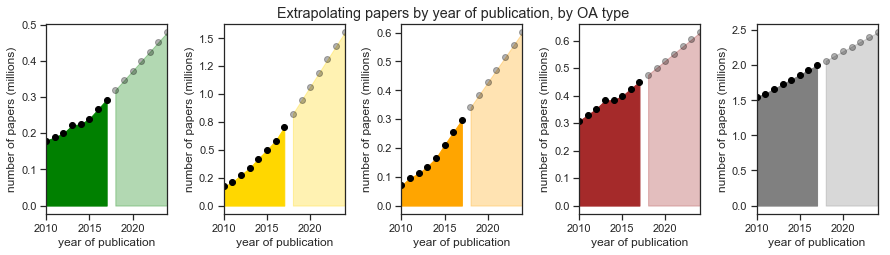

In [170]:

fig, axes = plt.subplots(1, len(oa_status_order), figsize=(12, 3), sharex=True, sharey=False)
axes_flatten = axes.flatten()
plt.tight_layout(pad=0, w_pad=2, h_pad=1)
plt.subplots_adjust(hspace=1)
naive_data = pd.DataFrame()
for i, graph_type in enumerate(oa_status_order):
    new_data = graph_naive_papers(graph_type, use_graph_type=False, now_delta_years=1, cumulative=False, ax=axes_flatten[i])
    naive_data = naive_data.append(new_data)
    


The prediction shows continued growth in the absolute number of OA articles, as can be seen in the figure above. Moreover, we also can see a growth in the percentage of all papers that are available as OA, as can be seen in the stacked area chart below..

The early years of this graph are similar to Figure 2 in Piwowar et al. (2018). There is one noteable difference: some of what was considered Bronze OA (and to a lesser extent hybrid OA) in the earlier paper is classified as Gold OA in the current analysis. This is due to an improvement in Unpaywall's algorithms. Originally, Unpaywall used the Directory of Open Access Journals (DOAJ) as the sole arbiter of whether a journal was "fully-OA." Unpaywall still uses DOAJ in this way, but it now also adds an empirical check for OA journals (if 100% of a journal's articles are OA, it is listed as an OA journal). This results in a more comprehensive and accurate list of fully-OA journals, which in turn moves some articles into Gold from Hybrid and Bronze. .

[cumulative -> total]


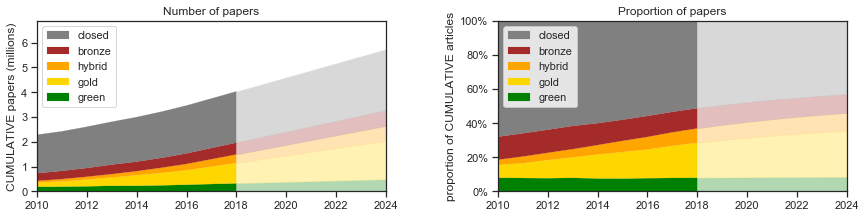

In [171]:
plot_totals_and_proportion(naive_data)

### Predicting number of papers at their time of availability   

The simple analysis above tells us how OA status varies by publication date. However, it glosses over a detail that become important when we endeavor to make OA prediction useful: *when* do papers become available?  [i think the question is more how much is OA when i look]

For Gold OA and Hybrid OA the answer is easy: the papers are OA at the time of publication. For Green and Bronze OA the answer is more complicated. Authors often upload their paper to a repository months or years after the official publication date of the paper, typically  because the journal has a policy that authors must wait a certain length of time (the "embargo period") before self-archiving. Funder policies that mandate Green OA often allow a delay between publication and availability (notably the National Institutes of Health [NIH] in the USA, accounting for most of the content in the large PubMed Central [PMC] repository). Finally, some journals open up their back catalogs once articles reach a certain age, which has been called "delayed OA" (Laakso and Björk, 2013) and we consider an important subset of Bronze.

We explore and model these dynamics below.

#### Green OA by the time of its availability


We can explore the delay between the time an article is published and when it becomes available as Green OA by comparing publication dates with dates of repository availability, available from each article's OAI-PMH record (as harvested by Unpaywall).

We plot the number of Green OA papers made available each year in the graph below, vs their date of publication. The first plot is a histogram of number of papers made available each year (one row for each year). The second plot is the same, but superimposes the articles made available in previous years. This stacked area represents the total cumulative number of Green OA papers that are available in that year -- if you were in that year and wondering what was available as Green OA that's what you'd find.

The third plot is a larger version of the availability as of 2018, showing the accumulation of availability. It allows us to appreciate that less than half of papers papers published in, say, 2015, were made available the same year -- most of the papers have been made available in subsequent years. The fourth plot is a slice in isolation, for clarity: the Green OA for articles with a Publication Date of 2015.


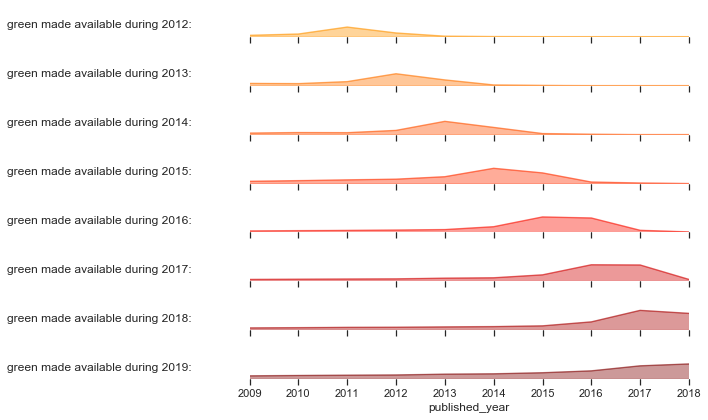

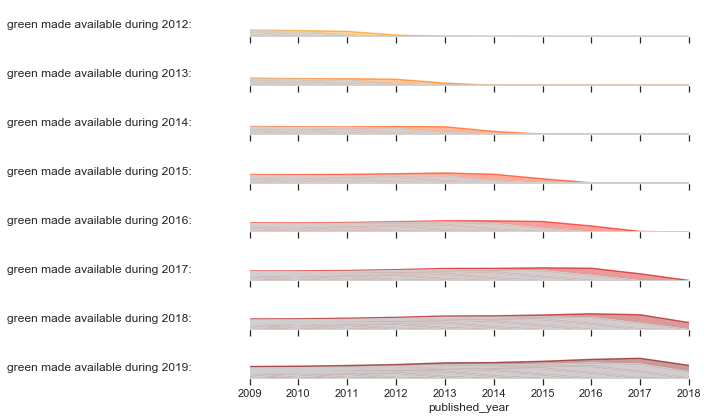

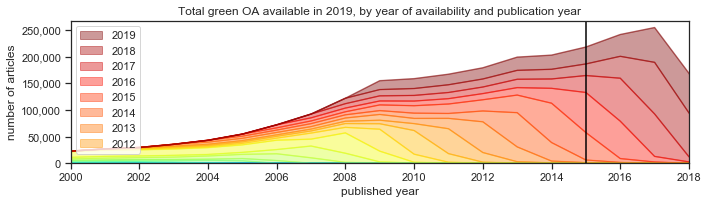

In [194]:
make_detailed_plots("green")

[could use clearer separation but figure labels will probably fix this]

[labels should change from "made available" to "available]

[normalize the y-axis differently, so these graph doesn't looks smaller?]


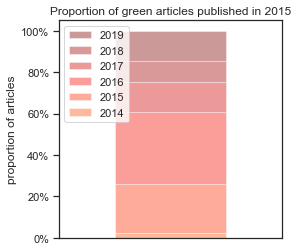

In [195]:
make_zoom_in_plot("green")

We will use these results in a future section when we predict number of accesses to Green OA content.


#### Bronze Delayed OA by the time of its availability


We approach the availability of Bronze Delayed OA the same way as we did with Green OA above.

We do not have a record of when Delayed OA papers became available, so we used a list of Delayed OA journals and their embargo periods to estimate the date of availability.

There was no publicly-available definitive list of Delayed OA journals, so we derived a list empirically based on the Unpaywall database. We cross-checked the list with journal policies as well as Laakso and Björk (2013) and these sources:

-   <https://www.elsevier.com/about/open-science/open-access/open-archive>

-   <http://highwire.stanford.edu/cgi/journalinfo#loc>

-   <https://www.ncbi.nlm.nih.gov/pmc/journals/?filter=t3&titles=current&search=journals#csvfile>

-   <https://en.wikipedia.org/wiki/Category:Delayed_open_access_journals>

The list includes 546 journals, with the following embargo lengths:

embargo	length (months)|number of journals
---|---
6	|58
12	|175
18	|137
24	|42
36	|71
48	|63
Total	|546

Using this list, 2.5 million articles are considered Delayed OA. Their breakdown by availability year and publication year follows. You can see the effect of the 12 and 18 month embargos, which cover more journals and those with higher volume.


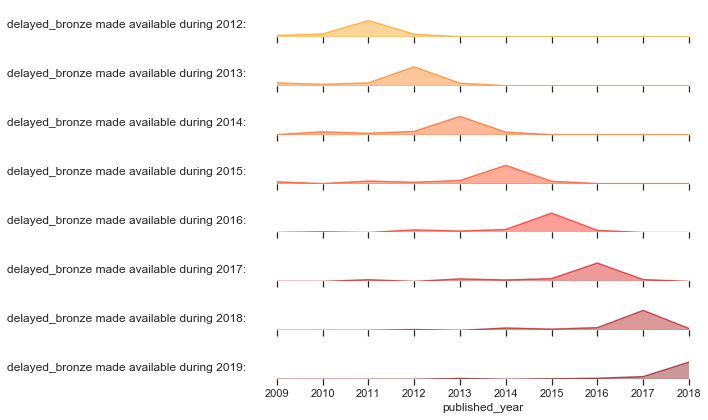

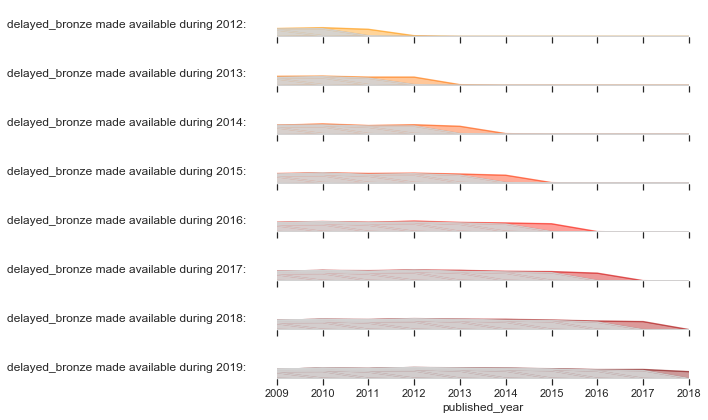

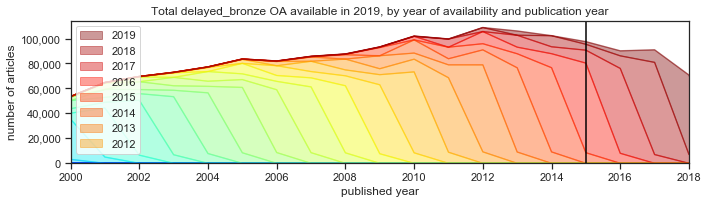

In [196]:
make_detailed_plots("delayed_bronze")

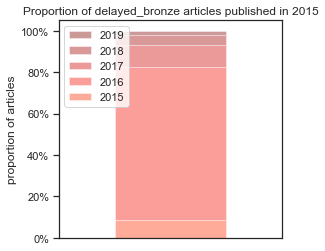

In [197]:
make_zoom_in_plot("delayed_bronze")

### Closed OA

### Predicting number of accesses

Now that we have an analysis of OA based on time of observation, rather than simply time of publication, we can extend our examination to include OA as a percentage of usage, rather than just number of articles.

To do this, we will examine data from the Unpaywall browser extension, as described in the Data section above. This data allows us to make inferences about overall readership trends--which in turn will help us make predictions about how OA will impact global readers of the research literature.

This will involve the following steps:

1.  calculate how often people are to want to access a paper, given its age and OA status

2.  calculate the number of papers there are of a given age and OA status in past and future years

3.  multiply these together to get the number of accesses that people would make in past and future years

 It is well known that readers are more interested in accessing newly-published articles, andindeed this trend can be seen in the Unpaywall usage logs. The figure below summarizes access requests by users of the Unpaywall extension between August 2018 and August 2019, by age of the article they wished to read. As expected, readers are most interested in articles published less than a year ago.


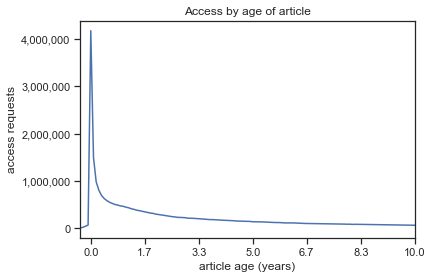

In [31]:
# hidden: code to query and graph 
%matplotlib inline

my_plot = data_usage_by_age_months_no_color_full_year.plot.line(x="article_age_months", y="num_accesses")
my_plot.set_xlim(-4, 120)
ticks = [round(x, 1) for x in my_plot.get_xticks()/12]  # convert months to years
my_plot.set_xticklabels(ticks);
my_plot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('article age (years)')
plt.ylabel('access requests')
plt.title("Access by age of article");
my_plot.get_legend().remove()

In [204]:
my_min = 2016
my_max = 2024
my_range = range(my_min, my_max)

graph_type = "gold"
all_predicted_papers = pd.DataFrame()
for i, graph_type in enumerate(graph_type_order):
    all_data = get_papers_by_availability_year_including_future(graph_type, my_min, my_max)
    all_data["graph_type"] = graph_type
    all_predicted_papers = all_predicted_papers.append(all_data)


How can we use this access data to predict the number of accesses that people will be interested in in the future? And how that differs from access demand in the past?


#### How often does someone want to access a paper, given its age and OA status

First, we use the access data we have from one specific month:  July 2019.  We group it by OA access type and plot it by age of the article:

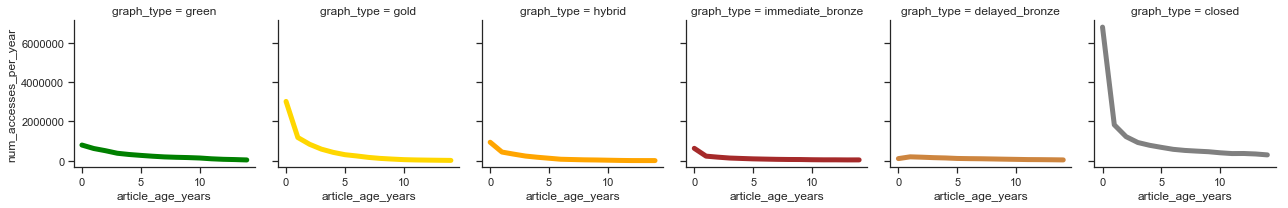

In [32]:

data = get_accesses_per_year_total()  
data_now = data.loc[data["article_age_years"] >= 0]
g = sns.FacetGrid(data_now, col="graph_type", hue="graph_type", col_order=graph_type_order, hue_order=graph_type_order, palette=my_cmap_graph_type)
kws = dict(linewidth=5)
g.map(plt.plot, "article_age_years", "num_accesses_per_year", **kws);


We also have the number of papers that were available in July 2019, by age of the article (here on the x axis called "article years from availability". [link this back to the earlier section, call it out by name. would be cool even to have these graphs in that section.]


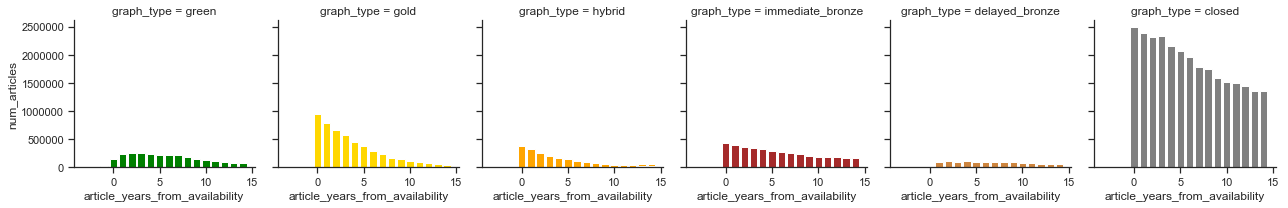

In [33]:

data = get_papers_by_availability_year_total(2018)  
data_now = data.loc[data["article_years_from_availability"] < 15]
g = sns.FacetGrid(data_now, col="graph_type", hue="graph_type", col_order=graph_type_order, hue_order=graph_type_order, palette=my_cmap_graph_type)
g.map(plt.bar, "article_years_from_availability", "num_articles");




Now for each of the OA types individually, we divide these signals by each other. This means that, for each OA type, we divide the number of times someone accessed an article of that was 0 years old (in other words, brand new--in this case published between July 2018 and July 2019) by the number of total articles that were 0 years old -- articles that were published since July 2018. Then we take the next age bucket, 1 year old, and divide the number of accesses to 1 year old articles by the number of articles available in July 2019 that were 1 year old. We do this for all age bins (15 are shown in the graphs).

The result of these divisions are the signals below: the number of accesses per article, for a given age and OA type.


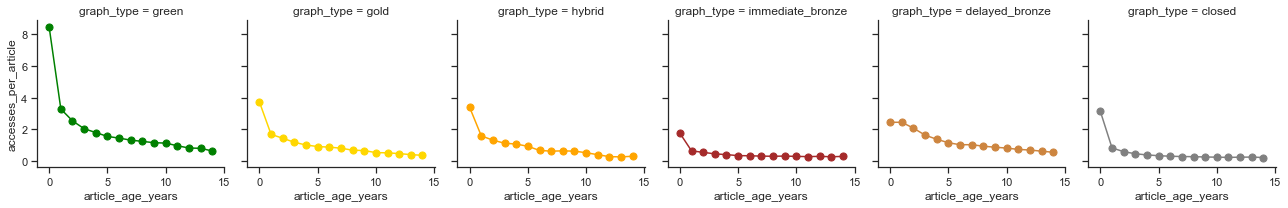

In [34]:

data = get_accesses_per_article_total()  
data_now = data.loc[data["article_age_years"] >= 0]
g = sns.FacetGrid(data_now, col="graph_type", hue="graph_type", col_order=graph_type_order, hue_order=graph_type_order, palette=my_cmap_graph_type)
kws = dict(s=50)
g.map(plt.scatter, "article_age_years", "accesses_per_article", **kws);
g.map(plt.plot, "article_age_years", "accesses_per_article");


#### How many papers are there of a given age and OA status



Because access patterns depend so heavily on recency of publication, to estimate how open access affects access rates we need to take into account the age when articles are made available. We will use the work we did in the "Predicting number of papers at their time of availability" section. The figure below shows the number of papers we calculate, then predict, for all OA types.

Each column of the figure is a type of OA (green, gold, hybrid, immediate bronze, delayed bronze, closed).

Each row is a year of availability assessment, from 2016 in the first row to 2023 in the last row.  [talk about what y axis is scaled to?]

Each plot is the number of papers available for that year and that OA type, by year of publication on the x axis.

Future years are calculated by assuming the new additions in future years will follow a similar pattern to 2018, subject to overall growth. The overall growth is assessed by a linear extrapolation on Year 0.   

[maybe transpose this so that it goes ltr in direction of time, insteaad of top to bottom, which is less common?]  [maybe lose dimming]


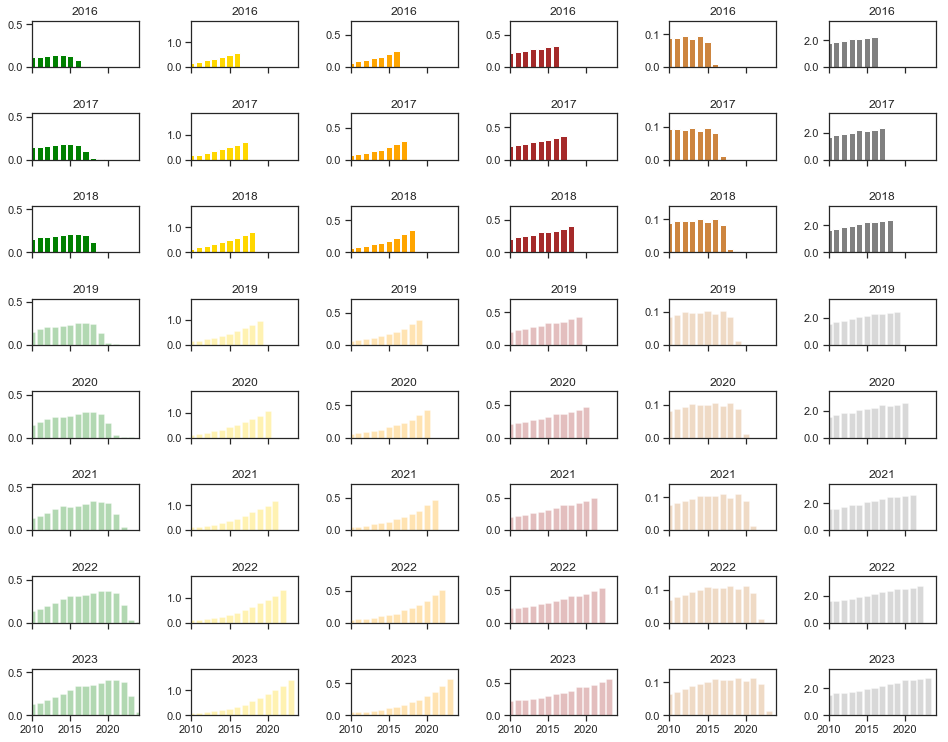

In [29]:

fig, axes = plt.subplots(len(my_range), len(graph_type_order), figsize=(13, 10), sharex=True, sharey=False)
axes_flatten = axes.flatten()
plt.tight_layout(pad=0, w_pad=2, h_pad=1)
plt.subplots_adjust(hspace=1)

i = 0
for observation_year in my_range:
    for graph_type in graph_type_order:
        y_max = all_predicted_papers.loc[all_predicted_papers.graph_type == graph_type]["num_articles"].max()
        this_data = all_predicted_papers.copy()
        this_data = this_data.loc[this_data.graph_type == graph_type]
        this_data = this_data.loc[this_data.prediction_year == observation_year]
        this_data["publication_date"] = [int(observation_year - a) for a in this_data.article_years_from_availability]
        new_data = graph_available_papers_in_observation_year_by_pubdate(graph_type, this_data, observation_year, ax=axes_flatten[i])
        axes_flatten[i].set_ylim(0, 1.2*y_max)
        i += 1


#### How many accesses do we predict in past and future years


To show how we'll estimate accesses, we'll use 2022 as an example. We use the 2022 row from the give above, and the graph it by age of article (rather than year of publication). This flips the direction of the x axis. In this graph to make the next steps more clear we also use a shared y axis across all OA types.


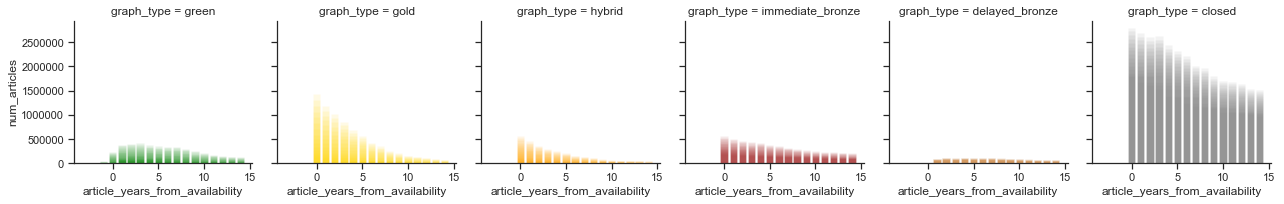

In [208]:

my_year = 2022
data = get_papers_by_availability_year_total(my_year)  
data_now = data.loc[data["article_years_from_availability"] < 15]
data_now["publication_year"] = my_year - data_now["article_years_from_availability"]
g = sns.FacetGrid(data_now, col="graph_type", hue="graph_type", col_order=graph_type_order, hue_order=graph_type_order, palette=my_cmap_graph_type)
kws = dict(alpha=0.1)
g.map(plt.bar, "article_years_from_availability", "num_articles", **kws);



Next, we'll use the signal we calculated in the section "How often does someone want to access a paper, given its age and OA status", which shows the number of accesses per article someone made in 2019. An assumption in our model is that this accesses-per-article probability stays the same across time, so we assume that it applies to 2022 as well.


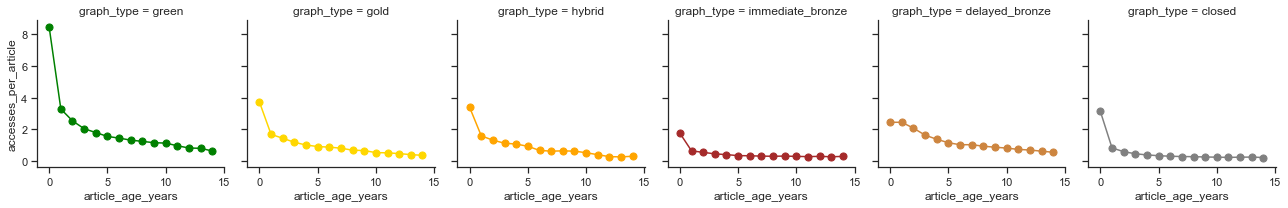

In [36]:

data = get_accesses_per_article_total()  
data_now = data.loc[data["article_age_years"] >= 0]
g = sns.FacetGrid(data_now, col="graph_type", hue="graph_type", col_order=graph_type_order, hue_order=graph_type_order, palette=my_cmap_graph_type)
kws = dict(s=50)
g.map(plt.scatter, "article_age_years", "accesses_per_article", **kws);
g.map(plt.plot, "article_age_years", "accesses_per_article");


Now we multiply these two signals together. We multiply them in a similar way that we divided signals in an earlier step -- we take each OA type in turn, and then take each age bin in turn. So the green OA point at 0 years in the graph below comes by multiplying the number of estimated articles in 2022 that are available as green OA and 0 years old by the number of "accesses-per-article" we calculated for green OA for articles that are 0 years old. We then do that calculation for every age bin, for every OA type, and get the graph below:


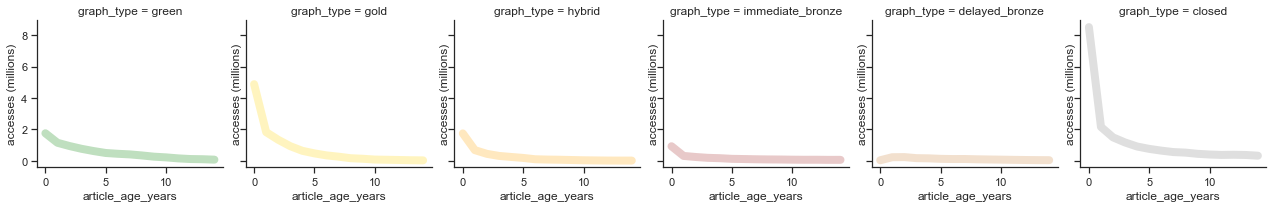

In [37]:

data = get_predicted_accesses_by_pubdate_total(my_year) 
data_now = data.loc[data["article_age_years"] < 15]
g = sns.FacetGrid(data_now, col="graph_type", hue="graph_type", col_order=graph_type_order, hue_order=graph_type_order, palette=my_cmap_graph_type)
kws = dict(alpha=0.25, linewidth=8)
g.map(plt.plot, "article_age_years", "accesses", **kws);
# kws = dict(alpha=1, linewidth=5, linestyle='dashed')
# g.map(plt.plot, "article_age_years", "accesses", **kws);
for ax in g.axes[0]:
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.0f}'.format(y/(1000*1000.0))))
    ax.set_ylabel("accesses (millions)")

Finally, an estimate of total number of accesses in 2022 comes from summing together the accesses in 2022 across all article ages. In other words, the green X in the graph below at year 2022 is the area under the green curve in the row above -- the sum of all accesses to green OA of age 0, age 1, age 2, age 3, etc.


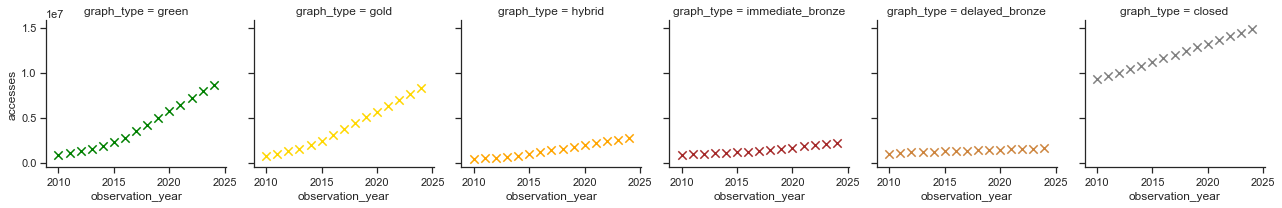

In [38]:

data = get_predicted_accesses_total(my_year)  
data_now = data.loc[data["observation_year"] >= 2010]
g = sns.FacetGrid(data_now, col="graph_type", hue="graph_type", col_order=graph_type_order, hue_order=graph_type_order, palette=my_cmap_graph_type)
kws = dict(marker="x", s=70)
g.map(plt.scatter, "observation_year", "accesses", **kws);

This gives us accesses for each year, 2010 to 2024, by OA type. The following graph is the same as the previous one, but without shared y axis so we can better see the relative trends. 


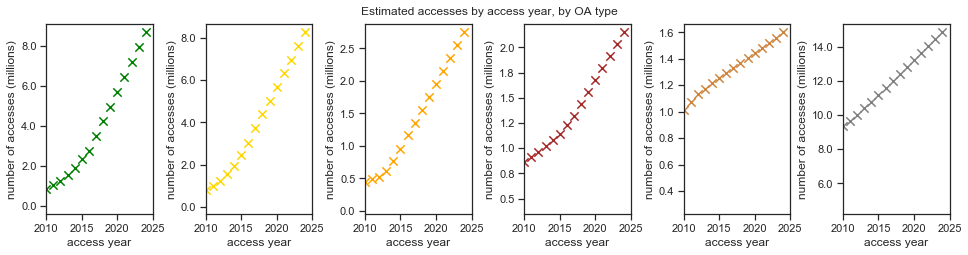

In [39]:
# Hi Heather

fig, axes = plt.subplots(1, len(graph_type_order), figsize=(13, 3), sharex=True, sharey=False)
axes_flatten = axes.flatten()
plt.tight_layout(pad=0, w_pad=2, h_pad=1)
plt.subplots_adjust(hspace=1)
prediction_of_accesses = pd.DataFrame()
for i, graph_type in enumerate(graph_type_order):
    if True:
#     if graph_type != "closed":
#         print graph_type
        new_data = graph_accesses(graph_type, ax=axes_flatten[i])
        new_data["graph_type"] = graph_type
        prediction_of_accesses = prediction_of_accesses.append(new_data)

We can plot these lines stacked on top of each other to see how the OA types change over time.


In [40]:

if True:
    total_accesses = pd.DataFrame()
    for graph_type in graph_type_order:
        new_predicted_accesses = get_predicted_accesses(graph_type)
        if "bronze" in graph_type:
            oa_status = "bronze"
        else:
            oa_status = graph_type
        new_predicted_accesses["oa_status"] = oa_status
        new_predicted_accesses["graph_type"] = graph_type
        total_accesses = total_accesses.append(new_predicted_accesses)
    total_accesses_bak = total_accesses
    # print total_accesses.head()


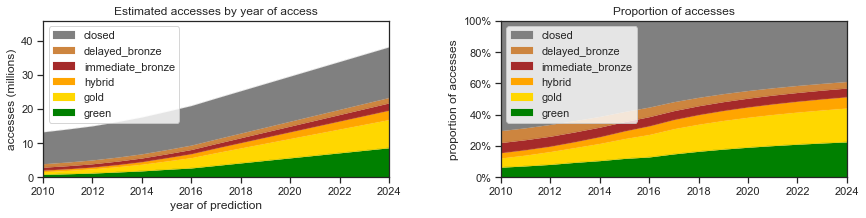

In [105]:

# not cumulative because cumulative accesses don't mean anything

if True:
    all_data_pivot = total_accesses.pivot_table(
                 index='observation_year', columns='graph_type', values=['accesses'], aggfunc=np.sum)\
           .sort_index(axis=1, level=1)\
           .swaplevel(0, 1, axis=1)
    all_data_pivot.columns = all_data_pivot.columns.levels[0]
    all_data_pivot
    # all_data_pivot[oa_status_order].plot.area(stacked=True, color=oa_status_colors)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=False)
    plt.tight_layout(pad=0, w_pad=2, h_pad=1)
    plt.subplots_adjust(hspace=1)

    all_data_pivot_graph = all_data_pivot
    all_data_pivot_graph = all_data_pivot.loc[all_data_pivot.index > 1960]
    my_plot = all_data_pivot_graph[graph_type_order].plot.area(stacked=True,  linewidth=.1, color=graph_type_colors, ax=ax1)
    ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.0f}'.format(y/(1000*1000.0))))
    ax1.set_xlabel('year of prediction')
    ax1.set_ylabel('accesses (millions)')
    ax1.set_xlim(2010, 2024)
    ax1.set_ylim(0, 1.2*max(all_data_pivot_graph.sum(1)))
    ax1.set_title("Estimated accesses by year of access");
    handles, labels = my_plot.get_legend_handles_labels(); my_plot.legend(reversed(handles[0:6]), reversed(labels[0:6]), loc='upper left');  # reverse to keep order consistent

    df_diff_proportional = all_data_pivot_graph.div(all_data_pivot_graph.sum(1), axis=0)
    my_plot = df_diff_proportional[graph_type_order].plot.area(stacked=True,  linewidth=.1, color=graph_type_colors, ax=ax2)
    my_plot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax2.set_xlabel('')
    ax2.set_ylabel('proportion of accesses')
    ax2.set_title("Proportion of accesses");
    ax2.set_xlim(2010, 2024)
    ax2.set_ylim(0, 1)
    handles, labels = my_plot.get_legend_handles_labels(); my_plot.legend(reversed(handles[0:6]), reversed(labels[0:6]), loc='upper left');  # reverse to keep order consistent

    plt.tight_layout(pad=.5, w_pad=4, h_pad=2.0)  




### Extending the model:  Growth of biorxiv

An advantage of building a model like we have above, is that we can now layer on alternate assumptions, and see how this affects the model. We can see how anticipated disruptions might affect OA in coming years.A comprehensive examination of all the alternative futures is of course outside the scope of this paper. However,  example will be illustrative.

Bioarxiv, a preprint server in biology, provides an excellent example.  As described in Abdill and Blekhman (2019), deposits into biorxiv are growing rapidly. If growth continues at the current rate, biorxiv could prove to be a major disruptor. It has the potential to have a large effect on growth of OA and the usage of OA particularly because the vast majority of the deposits are made available before article publication (and so are available during the most demanded time of usage).

We model the growth of biorxiv and its impact on OA availability here by extrapolating from biorxiv papers that:

-   were deposited before they were published (to simplify the model), and

-   were published in subscription journals.

These are plotted below, and then a logarithmic extrapolation is done to show the anticipated growth in otherwise-closed biorxiv papers through 2024.

[ maybe first show a graph with just the past, showing how well teh exp curve fits. then, "now that we've got a great candidate, etc...]


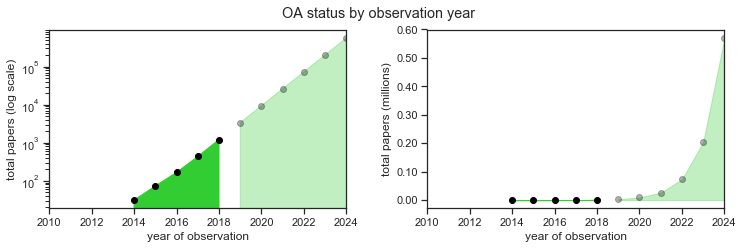

In [201]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=False)
plt.tight_layout(pad=.5, w_pad=4, h_pad=2.0) 
plt.subplots_adjust(hspace=1)
graph_available_papers_at_year_of_availability("biorxiv", ax=ax1);
ax1.set_yscale('log')
ax1.set_ylabel("total papers (log scale)")
graph_available_papers_at_year_of_availability("biorxiv", ax=ax2);




Next we want to roughly understand the impact of this growth of OA papers on access trends. For simplicity we use the generic green OA access trend derived in the Access section above (not enough biorxiv data exists yet to make its own specific curve). When we apply this access trend to the predicted growth of biorxiv papers, we estimate the following accesses over time: 

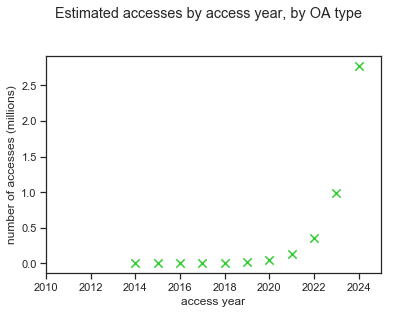

In [72]:
total_accesses_including_biorxiv = total_accesses.copy()
bioarxiv_accesses = graph_accesses("biorxiv");
bioarxiv_accesses["graph_type"] = "biorxiv"
bioarxiv_accesses["oa_status"] = "biorxiv"
total_accesses_including_biorxiv = total_accesses_including_biorxiv.append(bioarxiv_accesses)

Finally, we include these accesses in the total picture. As we can see, biorxiv has the potential to boost OA availability noticeably. [add numbers...in 2024, x%of all uses/accesses would be hosted on biorxiv (which isn't crazy given z% of the lit is biomed?)]


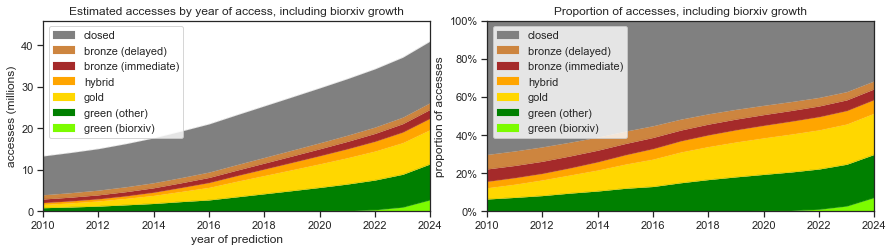

In [200]:
graph_type_colors_plus_biarxiv = ["lawngreen"] + graph_type_colors
graph_type_order_plus_biorxiv = ["biorxiv"] + graph_type_order
all_data_pivot_plus_biorxiv = total_accesses_including_biorxiv.pivot_table(
             index='observation_year', columns='graph_type', values=['accesses'], aggfunc=np.sum)\
       .sort_index(axis=1, level=1)\
       .swaplevel(0, 1, axis=1)
all_data_pivot_plus_biorxiv.columns = all_data_pivot_plus_biorxiv.columns.levels[0]
# all_data_pivot_plus_biorxiv["biorxiv"] = all_data_pivot_plus_biorxiv["biorxiv"].fillna(0)
# all_data_pivot_plus_biorxiv["closed"] -= all_data_pivot_plus_biorxiv["biorxiv"]
all_data_pivot_plus_biorxiv

plus_biorxiv_labels = [
    "green (biorxiv)",
    "green (other)",
    "gold",
    "hybrid",
    "bronze (immediate)",
    "bronze (delayed)",
    "closed"
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=False)
plt.tight_layout(pad=0, w_pad=2, h_pad=1)
plt.subplots_adjust(hspace=1)

all_data_pivot_plus_biorxiv_graph = all_data_pivot_plus_biorxiv
all_data_pivot_plus_biorxiv_graph = all_data_pivot_plus_biorxiv_graph.loc[all_data_pivot.index > 1960]
my_plot = all_data_pivot_plus_biorxiv_graph[graph_type_order_plus_bioarxiv].plot.area(stacked=True, color=graph_type_colors_plus_bioarxiv, ax=ax1, linewidth=0.1)
ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: '{0:,.0f}'.format(y/(1000*1000.0))))
ax1.set_xlabel('year of prediction')
ax1.set_ylabel('accesses (millions)')
ax1.set_xlim(2010, 2024)
ax1.set_ylim(0, 1.2*max(all_data_pivot_graph.sum(1)))
ax1.set_title("Estimated accesses by year of access, including biorxiv growth");
handles, labels = my_plot.get_legend_handles_labels(); my_plot.legend(reversed(handles[0:7]), reversed(plus_biorxiv_labels[0:7]), loc='upper left');  # reverse to keep order consistent

df_diff_proportional_plus_biorxiv = all_data_pivot_plus_biorxiv.div(all_data_pivot_graph.sum(1), axis=0)
my_plot = df_diff_proportional_plus_biorxiv[graph_type_order_plus_bioarxiv].plot.area(stacked=True, color=graph_type_colors_plus_bioarxiv, ax=ax2, linewidth=0.1)
my_plot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax2.set_xlabel('')
ax2.set_ylabel('proportion of accesses')
ax2.set_title("Proportion of accesses, including biorxiv growth");
ax2.set_xlim(2010, 2024)
ax2.set_ylim(0, 1)
handles, labels = my_plot.get_legend_handles_labels(); my_plot.legend(reversed(handles[0:7]), reversed(plus_biorxiv_labels[0:7]), loc='upper left');  # reverse to keep order consistent



*Next a bigger picture of the one above. Move it up to the summary at the top of the paper:*

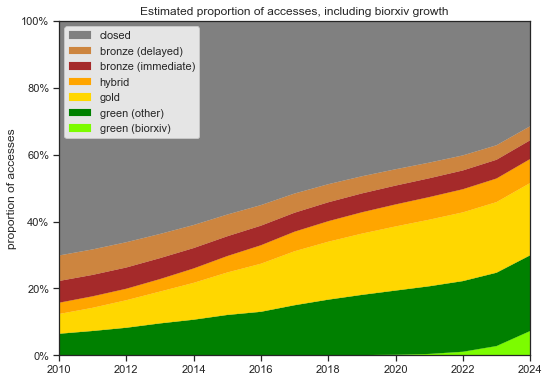

In [121]:
fig, ax2 = plt.subplots(1, 1, figsize=(7, 5), sharex=True, sharey=False)
plt.tight_layout(pad=0, w_pad=2, h_pad=1)
plt.subplots_adjust(hspace=1)

df_diff_proportional_plus_biorxiv_proportional = df_diff_proportional_plus_biorxiv.div(df_diff_proportional_plus_biorxiv.sum(1), axis=0)
my_plot = df_diff_proportional_plus_biorxiv_proportional[graph_type_order_plus_bioarxiv].plot.area(stacked=True, color=graph_type_colors_plus_bioarxiv, ax=ax2, linewidth=0.1)
my_plot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax2.set_xlabel('')
ax2.set_ylabel('proportion of accesses')
ax2.set_title("Estimated proportion of accesses, including biorxiv growth");
ax2.set_xlim(2010, 2024)
ax2.set_ylim(0, 1)
handles, labels = my_plot.get_legend_handles_labels(); my_plot.legend(reversed(handles[0:7]), reversed(plus_biorxiv_labels[0:7]), loc='upper left');  # reverse to keep order consistent
plt.show()


## Discussion



Needs writing still.  This is rough outline.

We found A, B, C.

This study has some limitations:
- Some limitations of this study are similar to Piwowar et al. (2018): it only considers journal articles with DOIs and the users of the Unpaywall extension may not be representative.
- Accesses are to Unpaywall right now -- intended to be representative -- Unpaywall had fewer users a few years ago and will likely have more in a few years.  This number of users as a given, we are interested in shape and relative values not absolutes.
- Summer is not representative access time

This area is ripe for futher research:
- other slices: by discipline, country, publisher
- disruptions to model
    - some are inherent in existing growth curves, but large ones warrent special inclusion
    - plan S 
    - change in embargo for existing mandates
    - increase in institutional self archiving
- more refined models
    - Could have customized download curves for different universities, scaled to number accesses and also subject interest.
    - by journal.  Heterogeneous by journal, for example some journals like Cell, delayed OA is more important. Obviously bioarxiv more relevant in some subject areas, so a big impact there.

And then a final sentence or two here.

## References

- Abdill, R.J., and Blekhman, R. (2019). Tracking the popularity and outcomes of all bioRxiv preprints. eLife 8.

- Antelman, K. (2017). Leveraging the growth of open access in library collection decision making. At the Helm: Leading Transformation. Association of College and Research Libraries 411–422.

- Laakso, M., and Björk, B.-C. (2013). Delayed open access: An overlooked high-impact category of openly available scientific literature. Journal of the American Society for Information Science and Technology 64, 1323–1329.

- Lewis, D.W. (2012). The Inevitability of Open Access. College & Research Libraries 73, 493–506.

- Piwowar, H., Priem, J., Larivière, V., Alperin, J.P., Matthias, L., Norlander, B., Farley, A., West, J., and Haustein, S. (2018). The state of OA: a large-scale analysis of the prevalence and impact of Open Access articles. PeerJ 6, e4375.



## Data and code availability


### Empirical Gold OA list

For now:  https://docs.google.com/spreadsheets/d/1bXeW6O2x_Jcy_NSri_BfLTvDZIPPf7S1bHkBIQm0G0c/edit?usp=sharing


### Empirical bronze delayed OA list

clean empirical list:
https://docs.google.com/spreadsheets/d/1_Ts-4cmbgo1w0o5slP1xnLT4mKFz26LIokS9UUhojzI/edit#gid=1865704084

policies:
https://docs.google.com/spreadsheets/d/1c2jMSQr8L_rwG5OpxsbdVqL7R7G1NRODD35I_nh4vCE/edit#gid=2091057127

### Study data

**HEATHER to do: save all sql data variables into files, upload to Zenodo**

### Analysis notebook

Viewable at https://nbviewer.jupyter.org/gist/hpiwowar/46c274c3e84d1676ac039ff576fe00e8?flush_cache=true

Export using "jupyter nbconvert downloads.ipynb --to html --TemplateExporter.exclude_input=True"
then can be viewed at
https://htmlpreview.github.io/?https://github.com/Impactstory/rickscafe-api/blob/master/downloads.html

## Competing Interests

The authors work at [Our Research](https://ourresearch.org/) (formerly Impactstory), a non-profit company that builds tools to make scholarly research more open, connected, and reusable, including Unpaywall.

## Funding

The authors received no funding for this study.